In [1]:
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 36.2 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=6ac108762850f2734bcbf0d66c2f9514acdd0f25e46fc9669ef3507c571325bd
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-_43cqe06
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-_43cqe06
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 79 kB

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.11 ; cuda:  cu113
detectron2: 0.6


In [3]:
!python -m pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%pwd

'/content'

In [7]:
%cd /content/drive/MyDrive/detectron2

/content/drive/MyDrive/detectron2


In [ ]:
!python /content/drive/MyDrive/detectron2/voc2coco.py /content/drive/MyDrive/detectron2/annotations output.json

Number of xml files: 853
Success: output.json


In [8]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("sample4", {}, "./output.json", "./images")

In [9]:
sample_metadata = MetadataCatalog.get("sample4")
dataset_dicts = DatasetCatalog.get("sample4")

WARNING [07/10 06:55:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/10 06:55:40 d2.data.datasets.coco]: Loaded 853 images in COCO format from ./output.json


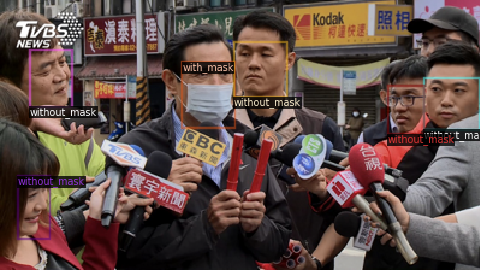

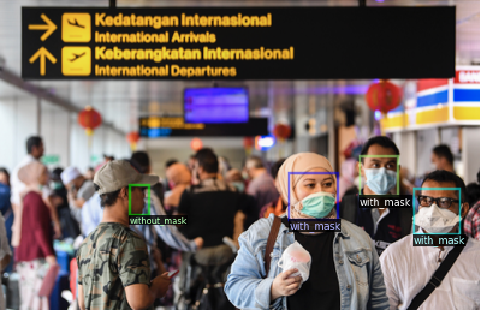

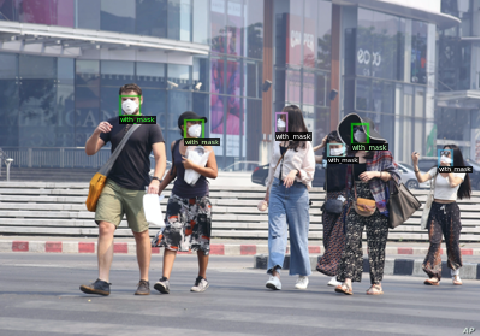

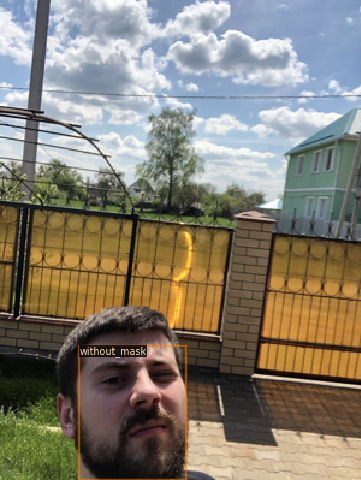

In [ ]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=1.2)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [10]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sample4",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1100    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE =128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[07/10 06:56:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/10 06:57:03 d2.utils.events]:  eta: 0:00:59  iter: 1019  total_loss: 0.4607  loss_cls: 0.1102  loss_box_reg: 0.282  loss_rpn_cls: 0.003424  loss_rpn_loc: 0.01781  time: 0.8533  data_time: 0.5399  lr: 0.0025  max_mem: 2641M
[07/10 06:57:19 d2.utils.events]:  eta: 0:00:42  iter: 1039  total_loss: 0.4414  loss_cls: 0.09484  loss_box_reg: 0.3131  loss_rpn_cls: 0.002095  loss_rpn_loc: 0.008508  time: 0.7986  data_time: 0.3102  lr: 0.0025  max_mem: 2641M
[07/10 06:57:34 d2.utils.events]:  eta: 0:00:27  iter: 1059  total_loss: 0.3896  loss_cls: 0.07457  loss_box_reg: 0.2846  loss_rpn_cls: 0.004837  loss_rpn_loc: 0.008555  time: 0.7857  data_time: 0.3450  lr: 0.0025  max_mem: 2641M
[07/10 06:57:49 d2.utils.events]:  eta: 0:00:14  iter: 1079  total_loss: 0.3633  loss_cls: 0.0833  loss_box_reg: 0.2556  loss_rpn_cls: 0.001605  loss_rpn_loc: 0.006853  time: 0.7766  data_time: 0.3215  lr: 0.0025  max_mem: 2641M
[07/10 06:58:06 d2.utils.events]:  eta: 0:00:00  iter: 1099  total_loss: 0.4083  los

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("sample4", )
predictor = DefaultPredictor(cfg)

[07/10 06:59:24 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

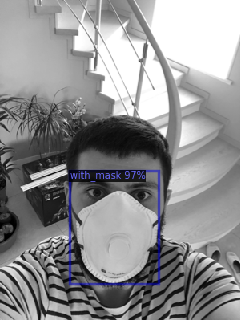

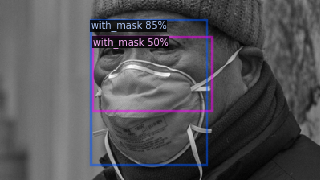

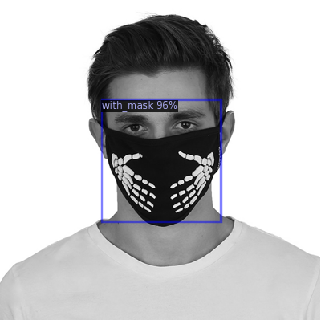

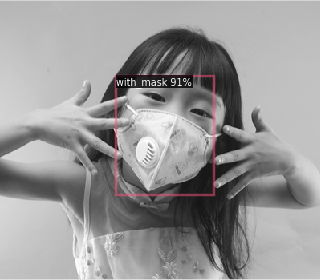

In [13]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [14]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()